citations:
emojifier deep learning.ai

In [2]:
import pandas as pd
import math
import csv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [3]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [5]:
dfDataDump = pd.read_csv('/home/archit/Desktop/ad_vs_organic/final_combined_lang_organic_duration3.csv').drop('Unnamed: 0', axis =1)
dfDataDump.columns

Index(['vid', 'channelId', 'duration', 'licensedContent', 'definition',
       'dislikeCount', 'commentCount', 'favoriteCount', 'viewCount',
       'likeCount', 'relevantTopicIds', 'topicIds', 'topicCategories', 'title',
       'description', 'tags', 'categoryId', 'channelTitle', 'publishedAt',
       'Channel Title', 'Channel Description', 'Channel Publish date',
       ' Channel hiddenSubscriberCount', 'Channel viewCount',
       'Channel subscriberCount', 'Channel commentCount', 'Channel videoCount',
       'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories', 'Lang',
       'cleanDescriptions'],
      dtype='object')

In [6]:
dfDataDump.shape

(62335, 36)

Next we will set up our input dataset and define the function for model training

In [7]:
def input_dataset(dfData, views =0, categories =[], country= ['IN']):
    """manipulates input dataframe according to input parameters.
    Args:
        dfData: input dataset
        views: minimum number of views in dfData.Default = 0.
        categories: list of categories to be present in final dataset.Default is empty list(all categories)
        country: List of countries whose videos should be present in dataSet. Default is India.
    Returns:
        dataset to train model on
    """
    # slice dataset with viewCount larger than views
    dfData = dfData[dfData['viewCount'] >= views]
    # concat dfData according to categories
    categoryIds =(dfData['categoryId'].dropna().unique()).tolist()
    # create temporary df
    tempDf = pd.DataFrame(columns = ['vid', 'channelId', 'duration', 'licensedContent', 'definition',
       'dislikeCount', 'commentCount', 'favoriteCount', 'viewCount',
       'likeCount', 'relevantTopicIds', 'topicIds', 'topicCategories', 'title',
       'description', 'tags', 'categoryId', 'channelTitle', 'publishedAt',
       'Channel Title', 'Channel Description', 'Channel Publish date',
       ' Channel hiddenSubscriberCount', 'Channel viewCount',
       'Channel subscriberCount', 'Channel commentCount', 'Channel videoCount',
       'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'])
    for categoryId in categoryIds:
        df = dfData[dfData['categoryId'] == categoryId]
        keys = []
        keys[0], keys[1] = tempDf['categoryId'][0], df['categoryId'][0]
        tempf = pd.concat([tempDf, df], ignore_index = True, keys = keys)
        
    # select dataframe according to categories
    if len(categories) != 0:
        dfData = tempDf.loc[categories]
    else:
        dfData = tempDf
    
    # choosing countries
    if len(country) != 0:
            dfData = dfData.loc[dfData['Channel country'] == country, ]
    else:
        dfData = dfData.loc[dfData['Channel country'] == 'IN']
        
    return dfData

In [11]:
def preprocessing(dfData):
    """drops irrelevant features, merges adStats and previous video stats
    Args:
    dfData: input DataSet
    Return:
    merged DataSet
    """
    # drop irrelevant features
    dfData = dfData.drop(['licensedContent', 'relevantTopicIds', 'topicIds', 'topicCategories', 'channelTitle', 'Channel Title', 'Channel Description', ' Channel hiddenSubscriberCount', 'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'], axis = 1)
    
    # load advertisement and previous stats dataset and clean
    dfAdStats = pd.read_csv('/home/archit/Desktop/ad_vs_organic/resultstats.csv').drop(['ch_id','Unnamed: 0'], axis =1)
    dfAdStats.rename(columns = {'video_id':'vid'}, inplace = True)
    dfPrevStats = pd.read_csv('/home/archit/Desktop/ad_vs_organic/previousVideoStats2.csv').drop(['Unnamed: 0'], axis =1)
    dfPrevStats.rename(columns = {'Id':'vid'}, inplace = True)

    # merge DataSet
    dfMergedData = dfData.merge(dfPrevStats, on = 'vid', how = 'left')
    dfMergedData = dfMergedData.merge(dfAdStats, on = 'vid', how = 'left')
    return dfMergedData

In [12]:
def feature_engineer(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount', 'categoryId', 'cleanDescriptions'],axis =1)
    dfData['is_english'] = dfData['Lang'].apply(lambda x: 1 if x=='en' else 0)
    dfData = dfData.drop('Lang', axis=1)
    
    
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['PrevCommentCount'] = dfData['PrevCommentCount'].fillna(0)
    dfData['PrevDislikeCount'] = dfData['PrevDislikeCount'].fillna(0)
    dfData['PrevLikeCount'] = dfData['PrevLikeCount'].fillna(0)
    dfData['PrevViewCount'] = dfData['PrevViewCount'].fillna(0)   
    dfData['duration'] = dfData['duration'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['Channel subscriberCount'] = dfData['Channel subscriberCount'].fillna(0)
    dfData['Definition'] = dfData['definition'].apply(lambda x: 1 if x=='hd' else 0)
    dfData = dfData.drop(['title','description','publishedAt','Channel viewCount','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [13]:
dfData = preprocessing(dfDataDump)
dfData.head()

,vid,channelId,duration,definition,dislikeCount,commentCount,favoriteCount,viewCount,likeCount,title,...,Channel videoCount,Lang,cleanDescriptions,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,PrevTitle,ad%
0,HGUPOfgKZak,UC05HXt0G85Q2RFNWP7oArYw,57.0,hd,0.0,10.0,0.0,884.0,98.0,Jamming with Darshan Raval at RadioMirchi (Ye ...,...,22.0,en,darshanraval subscribe press bell icon videos ...,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,j290K0z88o4,UC05HXt0G85Q2RFNWP7oArYw,237.0,hd,2.0,7.0,0.0,487.0,40.0,Ed Sheeran - Shape Of You (Indian Version) | H...,...,22.0,en,completely revived indian version billboard ch...,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,Wyha0AHJMCY,UC05HXt0G85Q2RFNWP7oArYw,217.0,hd,0.0,1.0,0.0,263.0,15.0,Pukarata Chala Hun Main | Live Rendition by Ac...,...,22.0,en,live rendition evergreen melody pukarta chala ...,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,IZEoofMLF0Q,UC05HXt0G85Q2RFNWP7oArYw,99.0,hd,2.0,3.0,0.0,203.0,18.0,Mann Bharrya | Unplugged | AcousticRishabh | B...,...,22.0,en,unplugged cover mann bharreya originally sung ...,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,tIfNeR7J_nQ,UC05HXt0G85Q2RFNWP7oArYw,194.0,hd,4.0,5.0,0.0,1306.0,42.0,Lag Jaa Gale | Live & Unplugged | Rishabh Tiwari,...,22.0,en,original song credits song lag jaa gale singer...,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [14]:
dfData.columns

Index(['vid', 'channelId', 'duration', 'definition', 'dislikeCount',
       'commentCount', 'favoriteCount', 'viewCount', 'likeCount', 'title',
       'description', 'tags', 'categoryId', 'publishedAt',
       'Channel Publish date', 'Channel viewCount', 'Channel subscriberCount',
       'Channel commentCount', 'Channel videoCount', 'Lang',
       'cleanDescriptions', 'PrevCommentCount', 'PrevDislikeCount',
       'PrevLikeCount', 'PrevPublishedAt', 'PrevViewCount', 'PrevTitle',
       'ad%'],
      dtype='object')

In [15]:
dfTrainingData = dfData[dfData['ad%'] == 0]
dfValidationData = dfData[dfData['ad%'] > 0]

In [18]:
df = feature_engineer(dfTrainingData)

In [19]:
df.columns

Index(['vid', 'duration', 'definition', 'dislikeCount', 'commentCount',
       'viewCount', 'likeCount', 'Channel subscriberCount',
       'Channel videoCount', 'PrevCommentCount', 'PrevDislikeCount',
       'PrevLikeCount', 'PrevViewCount', 'is_english', 'PublishedYear',
       'ChannelAge', 'channelViewCount', 'LikeDislikeRatio', 'Definition'],
      dtype='object')

In [20]:
X, y = df.drop('viewCount',axis = 1) , np.log(df['viewCount'])
X.shape

(56671, 18)

In [21]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.75, test_size = 0.25)

runnning stuff of LSTM

In [10]:
# select dfData with english language
#dfData = dfData[dfData['Lang'] == 'en'].reset_index()

In [23]:
def getVal(dictionary):
    """get value of single element dictionary
    """
    for key, val in dictionary.items():
        return val

In [24]:
descriptions = []
videos = list(train_X.vid)
for vid in videos:
    Dict = dfDataDump.loc[dfDataDump['vid'] == vid, 'cleanDescriptions'].to_dict()
    descriptions.append(getVal(Dict))

In [25]:
descriptions = pd.Series(descriptions)

In [26]:
length = pd.Series([len(description.split()) for description in descriptions])
maxLen = length.max()

In [27]:
maxLen

703

### validation data

In [49]:
dfValidate = pd.read_csv('/home/archit/Desktop/ad_vs_organic/validation_data_ad_vs_org2.csv')
dfValidate.drop('Unnamed: 0', axis =1, inplace=True)

In [52]:
dfValidate.columns

Index(['vid', 'channelId', 'duration', 'dislikeCount', 'commentCount',
       'favoriteCount', 'viewCount', 'likeCount', 'title', 'description',
       'tags', 'publishedAt', 'Channel Publish date', 'Channel viewCount',
       'Channel subscriberCount', 'Channel commentCount', 'Channel videoCount',
       'PrevCommentCount', 'PrevDislikeCount', 'PrevLikeCount',
       'PrevPublishedAt', 'PrevViewCount', 'PrevTitle', 'ad%'],
      dtype='object')

In [53]:
df = feature_engineer(dfValidate)

ValueError: labels ['categoryId' 'cleanDescriptions'] not contained in axis

descriptions = pd.read_csv('/home/archit/Desktop/ad vs organic/decriptions.csv')
decriptions.columns

# preprocess descriptions for glove embedding
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


dfData['cleanDescriptions']=dfData['description'].map(lambda s:preprocess(s)) 

In [29]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/home/archit/Desktop/ad_vs_organic/glove.6B.50d.txt')

In [30]:
word = "the"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of the in the vocabulary is 357266
the 289846th word in the vocabulary is potatos


### Scaling data for applying before to neural nets

In [31]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [32]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

In [33]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["duration"] = log_normalize(examples_dataframe["duration"])
  processed_features["dislikeCount"] = log_normalize(examples_dataframe["dislikeCount"])
  processed_features["commentCount"] = log_normalize(examples_dataframe["commentCount"])
  processed_features["likeCount"] = log_normalize(examples_dataframe["likeCount"])
  processed_features["Channel subscriberCount"] = linear_scale(examples_dataframe["Channel subscriberCount"])
  processed_features["Channel videoCount"] = linear_scale(examples_dataframe["Channel videoCount"])
  processed_features["PrevCommentCount"] = log_normalize(examples_dataframe["PrevCommentCount"])
  processed_features["PrevDislikeCount"] = log_normalize(examples_dataframe["PrevDislikeCount"])
  processed_features["PrevViewCount"] = log_normalize(examples_dataframe["PrevViewCount"])
  processed_features["LikeDislikeRatio"] = linear_scale(examples_dataframe["LikeDislikeRatio"])
  processed_features["channelViewCount"] = log_normalize(examples_dataframe["channelViewCount"])

    
  return processed_features

normalized_dataframe = normalize_linear_scale(train_X)

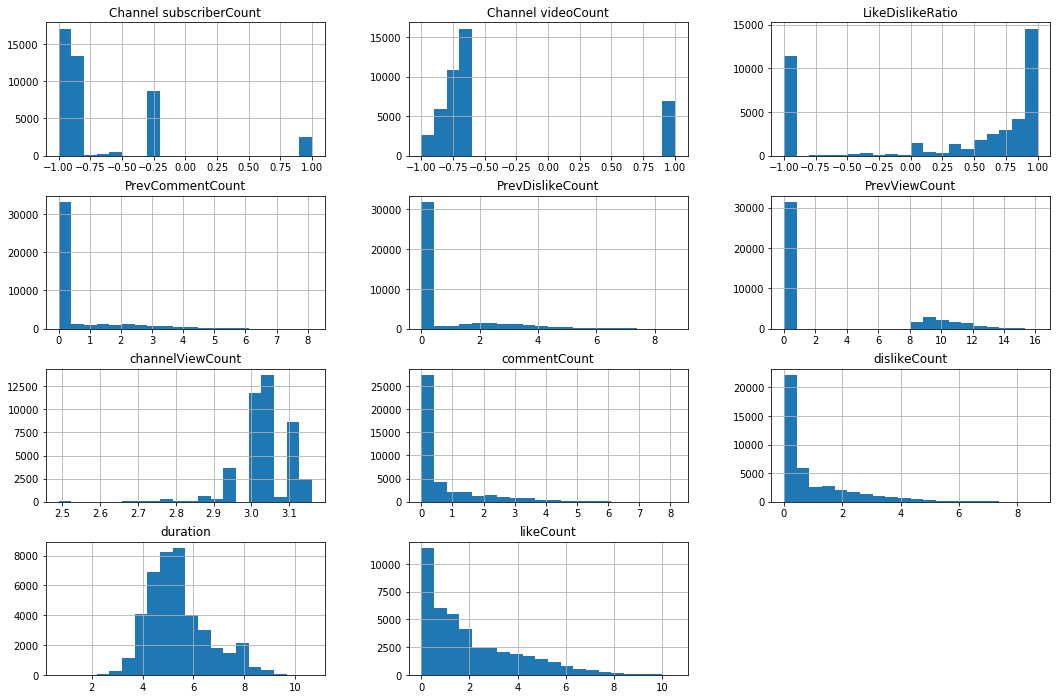

In [29]:
_ = normalized_dataframe.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [34]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint

np.random.seed(1)

Using TensorFlow backend.


In [35]:
# sentences_to_indices

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = [w.lower() for w in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = word_to_index[w]
            except:
                X_indices[i, j] = word_to_index['the']
            # Increment j to j + 1
            j += 1
            
    
    return X_indices

In [36]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [37]:
# pretrained_embedding_layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [38]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

Instructions for updating:
Colocations handled automatically by placer.
weights[0][1][3] = -0.3403


In [39]:
def PREDICT_USING_TEXT_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the PREDICT_USING_TEXT-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype='int32', name = 'main_input')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    lstm_out = LSTM(128, return_sequences=False)(X)
    
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    auxiliary_output = Dense(5)(X)
    # Add a softmax activation
    auxiliary_output = Activation('softmax')(auxiliary_output)
    
    
    # Here we insert the auxiliary loss, allowing the LSTM and Embedding layer to be trained smoothly even though the
    # main loss will be much higher in the model
    
    # at this time we feed our auxillary input data by concatenating it with the Lstm output
    auxiliary_input = Input(shape = (16,), name = 'auxiliary_input')
    x = concatenate([lstm_out, auxiliary_input])
    
    # stack a deep densely connected network on top
    x = Dense(512, activation='tanh')(x)
    x = Dense(512, activation='linear')(x)
    
    x = LeakyReLU(alpha=0.001)(x)
    x = Dense(512, activation='tanh')(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='linear')(x)
    x = Dense(128, activation='linear')(x)

    main_output = Dense(1, name = 'main_output')(x)
    
    
    # define model with two inputs and two outputs
    model = Model(inputs=[sentence_indices, auxiliary_input], outputs= main_output)
    
    ### END CODE HERE ###
    
    return model

In [40]:
model = PREDICT_USING_TEXT_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 703)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 703, 50)      20000050    main_input[0][0]                 
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 703, 128)     91648       embedding_2[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 703, 128)     0           lstm_1[0][0]                

In [41]:
model.load_weights("/home/archit/Desktop/ad_vs_organic/LStM/weights-improvement-01-3.68.hdf5")

In [42]:
# optimizer for regression stacking
adam = Adam(lr=0.0002, decay = 0.00001)

In [43]:
model.compile(loss='mean_squared_error', optimizer=adam)

In [ ]:
X_test_indices = sentences_to_indices(descriptions.values, word_to_index, maxLen)

In [ ]:
model.evaluate(model.fit({'main_input':X_train_indices, 'auxiliary_input': train_X}, {'main_output': train_y})

In [89]:
#train_X.drop('definition', axis=1, inplace=True)

In [45]:
train_X.columns

Index(['duration', 'dislikeCount', 'commentCount', 'likeCount',
       'Channel subscriberCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevViewCount', 'is_english',
       'PublishedYear', 'ChannelAge', 'channelViewCount', 'LikeDislikeRatio',
       'Definition'],
      dtype='object')

In [44]:
train_X.drop('definition', axis=1, inplace=True)

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
X_train_indices = sentences_to_indices(descriptions.values, word_to_index, maxLen)

In [ ]:
filepath="/home/archit/Desktop/ad_vs_organic/LStM/weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit({'main_input':X_train_indices, 'auxiliary_input': train_X}, {'main_output': train_y}, epochs = 50, batch_size = 32, callbacks=callbacks_list, shuffle=True)

Epoch 1/50
42503/42503 [==============================] - 2830s 67ms/step - loss: 3.6794

Epoch 00001: loss improved from inf to 3.67941, saving model to /home/archit/Desktop/ad_vs_organic/LStM/weights-improvement-01-3.68.hdf5
Epoch 2/50
16672/42503 [==========>...................] - ETA: 29:11 - loss: 4.2539

In [1]:
model.load_weights("/home/archit/Desktop/ad_vs_organic/LStM/weights-improvement-01-3.68.hdf5")

NameError: name 'model' is not defined

In [ ]:
# save the model
from keras.models import load_model
model.save('/home/archit/Desktop/ad vs organic/ad_vs_organic_keras_model.h5')

Now we will use standard metrics and evaluate our result

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [ ]:
r2_score(dfVal['ad%'],dfVal['Predicted Ad %'])

In [ ]:
np.sqrt(mean_squared_error(dfVal['ad%'],dfVal['Predicted Ad %']))

In [ ]:
mean_absolute_error(dfVal['ad%'],dfVal['Predicted Ad %'])

In [ ]:
bins =int( (dfVal['Diff'].max() - dfVal['Diff'].min())/5)
gh = plt.hist(dfVal['Diff'], bins = bins)
freq, error = gh[0], gh[1]
plt.ylabel('Number of videos')
plt.xlabel('error')
plt.title('Frequiency table of diff in ad%')
plt.show()

In [ ]:
freq = freq.astype('int64')
dfErr = pd.DataFrame()
dfErr['Error'] = pd.Series(error)
dfErr['Frequency'] = pd.Series(freq)
dfErr['Frequency Percentage'] = dfErr['Frequency']/ dfErr['Frequency'].sum() * 100
dfErr

Now we will look for videos with error in prediction > 30 and figure out why.

In [ ]:
dfErr[np.abs(dfErr['Error'])>30]

In [29]:
# Loading ad stats dataset
dfAdStats = pd.read_csv('/home/archit/Desktop/ad vs organic/resultstats.csv')
dfAdStats2 = dfAdStats.drop(['ch_id','Unnamed: 0'], axis =1)
dfAdStats2.rename(columns = {'video_id':'vid'}, inplace = True)
dfAdStats2.shape

(246184, 2)

In [41]:
# Loading perv stats dataset
dfPrevStats = pd.read_csv('/home/archit/Desktop/ad vs organic/previousVideoStats2.csv')
dfPrevStats = dfPrevStats.drop(['Unnamed: 0'], axis =1)
dfPrevStats.rename(columns = {'Id':'vid'}, inplace = True)

dfPrevStats.head()

,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,PrevTitle,vid
0,9.0,5.0,112.0,2016-08-25T03:48:52.000Z,21007.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 13 - Hà...,NaN
1,7.0,6.0,77.0,2016-11-15T06:59:55.000Z,19326.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 14 - Kh...,LPqCSwCNI5w
2,28.0,12.0,109.0,2016-11-15T07:01:46.000Z,33071.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 17 - Gi...,0LGl5jbnrlU
3,8.0,9.0,84.0,2016-11-15T07:01:55.000Z,29516.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 18 - C...,jFFSYwdku9M
4,12.0,18.0,145.0,2016-11-15T07:02:03.000Z,49653.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 19 - Ăn...,HvFNGb-nrRU


### Merging Dataset

In [42]:
dfMergedData = dfData2.merge(dfPrevStats, on = 'vid', how = 'left')
dfMergedData = dfMergedData.merge(dfAdStats2, on = 'vid', how = 'left')

In [43]:
dfMergedData.columns

Index(['Unnamed: 0', 'vid', 'channelId', 'duration', 'dislikeCount',
       'commentCount', 'favoriteCount', 'viewCount', 'likeCount', 'title',
       'description', 'tags', 'categoryId', 'publishedAt',
       'Channel Publish date', 'Channel viewCount', 'Channel subscriberCount',
       'Channel commentCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevPublishedAt', 'PrevViewCount',
       'PrevTitle', 'ad%'],
      dtype='object')

In [44]:
dfMergedData.to_csv("/home/archit/Desktop/ad vs organic/merged_data_ad_vs_org.csv")

In [45]:
dfMergedData = pd.read_csv('/home/archit/Desktop/ad vs organic/merged_data_ad_vs_org.csv')

### Picking up traininig set and validation set

In [46]:
dfTrainingSet = dfMergedData.loc[dfMergedData['ad%'] == 0,]
dfTrainingSet.shape

(112873, 27)

In [47]:
dfValidationSet = dfMergedData.loc[dfMergedData['ad%']>0, ]

dfValidationSet.shape

(8003, 27)

dfTrainingSet.to_csv("/home/archit/Desktop/ad vs organic/training_data_ad_vs_org3.csv")


In [48]:
dfValidationSet['orgViews'] = dfValidationSet['viewCount']*(100-dfValidationSet['ad%'])

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
dfValidationSet.drop('viewCount', axis=1, inplace= True)
dfValidationSet.rename(columns = {'orgViews':'viewCount'}, inplace = True)

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/archit/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [23]:
dfTrainingSet = pd.concat([dfTrainingSet, dfValidationSet], ignore_index = True)

In [24]:
dfTrainingSet.shape

(36515, 26)

In [25]:
dfValidationSet.to_csv('/home/archit/Desktop/ad vs organic/validation_data_ad_vs_org3.csv')

### Feature engineering


In [50]:
def feature_engineer(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount', 'categoryId'],axis =1)
    
    
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['PrevCommentCount'] = dfData['PrevCommentCount'].fillna(0)
    dfData['PrevDislikeCount'] = dfData['PrevDislikeCount'].fillna(0)
    dfData['PrevLikeCount'] = dfData['PrevLikeCount'].fillna(0)
    dfData['PrevViewCount'] = dfData['PrevViewCount'].fillna(0)   
    dfData['duration'] = dfData['duration'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['Channel subscriberCount'] = dfData['Channel subscriberCount'].fillna(0)
    dfData = dfData.drop(['title','description','publishedAt','Channel viewCount','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [51]:
def feature_engineer2(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount'],axis =1)
    
    dfData = dfData.dropna()
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData = dfData.drop(['title','description','publishedAt','','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [52]:
df = feature_engineer(dfTrainingSet)
#df.to_csv('/home/archit/Desktop/ad vs organic/trainSet2.csv')

In [61]:
X, y = df.drop('viewCount',axis = 1) , np.log(df['viewCount'])
X = X.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
X.shape

ValueError: labels ['Unnamed: 0' 'Unnamed: 0.1'] not contained in axis

In [69]:
X.columns

Index(['vid', 'duration', 'dislikeCount', 'commentCount', 'likeCount',
       'Channel subscriberCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevViewCount', 'PublishedYear',
       'ChannelAge', 'channelViewCount', 'LikeDislikeRatio'],
      dtype='object')

In [55]:
#X.to_csv('/home/archit/Desktop/ad vs organic/trainSET.csv')

### Modeling

In [70]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
#from xgboost import XGBClassifier, XGBRegressor

In [71]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.75, test_size = 0.25)

train_X_id, train_X = train_X.vid, train_X.drop('vid', axis = 1)
test_X_id, test_X = test_X.vid, test_X.drop('vid', axis = 1)

reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

import pickle
pickle.dump(reg, open("Gbr005.pickle.dat", "wb"))

In [72]:
pred = reg.predict(test_X)

In [73]:
size = test_y.shape[0]
test_yL = test_y.tolist()
predL = pred.tolist()
exActView = []
exPredView = []
diff = []
sqErr = []
mape={}
for i in range(0, size):
    exActView.append(math.exp(test_yL[i]))
    exPredView.append(math.exp(predL[i]))
    diff.append(exActView[i] - exPredView[i])
    sqErr.append(math.pow(diff[i], 2))
rmse = math.sqrt(sum(sqErr) /size)/ (test_y.max() - test_y.min())
dfEval = pd.DataFrame({'Id':test_X_id, 'Actual' : exActView, 'Pred': exPredView, 'Diff': diff})
dfEval.head()

,Actual,Diff,Id,Pred
44138,411.0,101.860164,lhpiPhfw8m8,309.139836
31600,881.0,-105.292991,2DEfSW3e3Hg,986.292991
27166,533.0,-201.823546,ZlBuyx8qz64,734.823546
67319,3926.0,1070.292623,fM38i1eHr98,2855.707377
42187,385.0,200.500859,_R4DWeJhz7Y,184.499141


In [74]:
print("Rmse of the regressormodel is:" + str(rmse))

Rmse of the regressormodel is:2387.4454790550158


In [75]:
1011.0650776175543/dfEval['Actual'].mean()

0.04029664809978987

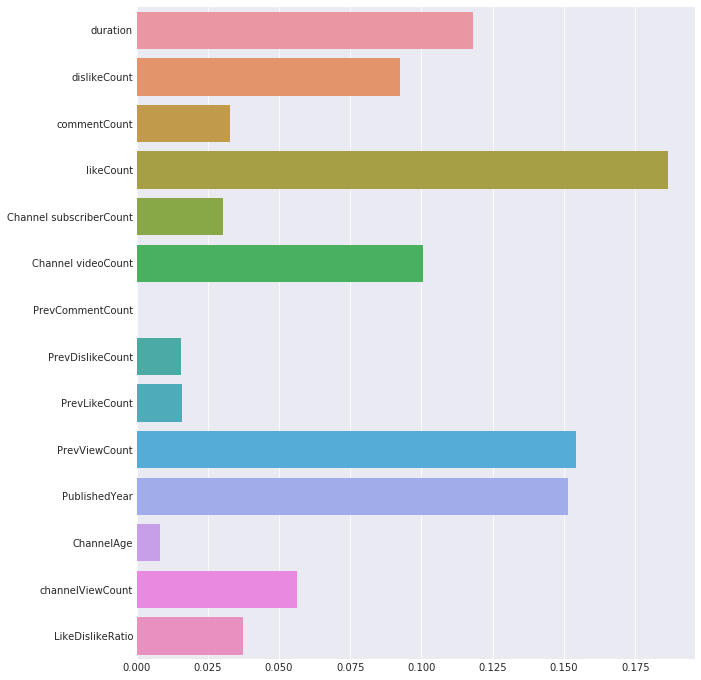

In [76]:
X = X.drop('vid', axis = 1)
sns.set_style('darkgrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

### Modeling on validation set

In [91]:
df = feature_engineer(dfValidationSet)